In [1]:
# === CNT: Observer-Gauge Invariance for Early Warnings (OGI-EW) ===
# Single mega cell
# Requirements: numpy, pandas, matplotlib, scipy (optional for signal), but code avoids scipy unless present.
# It will save a small bundle into ./ogi_ew_runs/<timestamp> by default; change BASE outdir as needed.

import os, uuid, math, json, time, shutil, warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- Config ----------
SEED            = 42
T               = 4000          # total timesteps
WINDOW          = 200           # rolling window for covariance
STEP_DRIFT      = 0.0005        # how fast the AR coefficient approaches 1.0
OBS_DIM         = 6             # number of observed sensors (>= latent dim)
LATENT_DIM      = 2             # fixed for this demo
N_TRIALS        = 40            # number of random observer gauges to test
ORTH_ONLY       = True          # True: use random orthogonal + permutations; False: also test arbitrary invertible (breaks invariance intentionally)
OUT_BASE        = os.path.join(".", "ogi_ew_runs")
STAMP           = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ") + "_" + uuid.uuid4().hex[:8]
OUT_DIR         = os.path.join(OUT_BASE, f"ogi_ew_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED)

# ---------- Helpers ----------
def ar1_scheduled_phi(t, t_max, start=0.90, end=0.999):
    # Smooth drift of AR coefficient toward 1.0 (critical slowing down)
    # Use a gentle logistic-ish schedule for shoulder + tail control
    x = t / t_max
    return start + (end - start) * (1.0 / (1.0 + np.exp(-8*(x-0.6))))  # quiet start, fast middle, slow tail

def simulate_latent_system(T, latent_dim=2, step_drift=STEP_DRIFT):
    """
    Simulate a 2D coupled latent process whose effective AR coefficient approaches 1.
    x(t+1) = A(t) x(t) + eta
    A(t): rotation + shrinking/growing along principal axes so spectral radius increases toward 1.
    """
    x = np.zeros((T, latent_dim))
    A_series = np.zeros((T, latent_dim, latent_dim))
    # Fixed rotation for gentle coupling
    theta = 0.15
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    # Start slightly stable, end near critical
    for t in range(T-1):
        phi = ar1_scheduled_phi(t, T-1, start=0.92, end=0.9993)
        # slight anisotropy so one axis leads the approach
        S = np.diag([phi, 0.98*phi])
        A = R @ S @ np.linalg.inv(R)
        A_series[t] = A
        eta = 0.05*np.random.randn(latent_dim)
        x[t+1] = A @ x[t] + eta
    A_series[-1] = A_series[-2]
    return x, A_series

def random_orthogonal(n):
    """Generate a random orthogonal matrix via QR."""
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    # enforce det +1 (proper rotation) for consistency
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    return Q

def embed_latent_to_observed(latent, obs_dim=OBS_DIM):
    """Random linear embedding into a higher-dim observed space, then orthonormalize columns."""
    L = np.random.randn(obs_dim, latent.shape[1])
    # Orthonormalize columns of L so different runs don't scale metrics
    Q, _ = np.linalg.qr(L)
    Y = latent @ Q.T[:,:latent.shape[1]].T  # (T, latent_dim) * (latent_dim, obs_dim) -> (T, obs_dim)? Careful
    # Correct shape: we want (T, obs_dim). Use (obs_dim x latent_dim) as map: Y = X @ L^T
    L = Q[:, :latent.shape[1]]                       # (obs_dim, latent_dim)
    Y = latent @ L.T                                 # (T, obs_dim)
    return Y, L

def rolling_top_eig(timeseries, window=WINDOW):
    """
    Compute the rolling top eigenvalue of the (z-scored) covariance over a window.
    Returns array of length T with NaN for first (window-1) entries.
    """
    X = (timeseries - np.nanmean(timeseries, axis=0)) / (np.nanstd(timeseries, axis=0) + 1e-12)
    T = X.shape[0]
    lam = np.full(T, np.nan)
    for t in range(window-1, T):
        C = np.cov(X[t-window+1:t+1].T)
        # numerical guard
        C = 0.5*(C + C.T)
        w = np.linalg.eigvalsh(C)
        lam[t] = np.max(w)
    return lam

def theta_star_from_curve(curve, win=WINDOW):
    """
    Define Θ* as the argmax of the smoothed *gradient* of the top eigenvalue curve.
    Intuition: the steepest ascent in collective variance marks the on-ramp to critical slowing.
    """
    v = curve.copy()
    # smooth with simple moving average
    k = max(5, win//20)
    if k % 2 == 0: k += 1
    pad = k//2
    vv = np.convolve(np.nan_to_num(v, nan=np.nanmean(v[~np.isnan(v)])), np.ones(k)/k, mode="same")
    # gradient
    g = np.gradient(vv)
    # ignore early segment with NaNs
    start = win + k
    idx = np.argmax(g[start:]) + start
    return int(idx), dict(k=k, start=start, theta_value=float(v[idx]), grad=float(g[idx]))

def gauge_pack(Y, orth_only=True):
    """
    Produce gauge-transformed versions of observed data:
     - permutations of sensors
     - random orthogonal rotations in sensor space
     - (optionally) general invertible transforms (to intentionally break invariance, if orth_only=False)
    Return list of (name, Y_transformed)
    """
    outs = []
    T, D = Y.shape
    # permutation
    perm = np.random.permutation(D)
    outs.append((f"perm", Y[:, perm]))

    # orthogonal rotations
    Q = random_orthogonal(D)
    outs.append((f"orth", Y @ Q))

    # orth + perm
    Q2 = random_orthogonal(D)
    perm2 = np.random.permutation(D)
    outs.append((f"orth+perm", (Y @ Q2)[:, perm2]))

    if not orth_only:
        # arbitrary invertible (breaks metric scale—should still keep Θ* similar, but may drift)
        A = np.random.randn(D, D)
        if np.linalg.matrix_rank(A) == D:
            outs.append((f"general_inv", Y @ A))
    return outs

def invariant_check(latent_X, obs_dim=OBS_DIM, n_trials=N_TRIALS, orth_only=ORTH_ONLY, window=WINDOW):
    # baseline embed
    Y, L = embed_latent_to_observed(latent_X, obs_dim=obs_dim)
    base_curve = rolling_top_eig(Y, window=window)
    base_theta, base_meta = theta_star_from_curve(base_curve, win=window)

    rows = []
    for i in range(n_trials):
        for name, Yg in gauge_pack(Y, orth_only=orth_only):
            lam = rolling_top_eig(Yg, window=window)
            th, meta = theta_star_from_curve(lam, win=window)
            rows.append(dict(trial=i, gauge=name, theta=th, theta_val=meta["theta_value"], grad=meta["grad"]))
    df = pd.DataFrame(rows)
    return base_theta, base_meta, df, base_curve

def ci_mean(a, alpha=0.05):
    a = np.asarray(a, dtype=float)
    a = a[~np.isnan(a)]
    if a.size == 0:
        return np.nan, (np.nan, np.nan)
    m = np.mean(a)
    s = np.std(a, ddof=1) if a.size > 1 else 0.0
    # normal approx
    from math import sqrt
    z = 1.96 if abs(alpha-0.05) < 1e-9 else 1.96
    lo, hi = m - z*s/np.sqrt(max(1,a.size)), m + z*s/np.sqrt(max(1,a.size))
    return m, (lo, hi)

# ---------- Run ----------
latent, A_series = simulate_latent_system(T, latent_dim=LATENT_DIM)
base_theta, base_meta, df, base_curve = invariant_check(latent, obs_dim=OBS_DIM, n_trials=N_TRIALS, orth_only=ORTH_ONLY, window=WINDOW)

# compute deviations
df["theta_delta"] = df["theta"] - base_theta
by = df.groupby("gauge")["theta_delta"]
summ = by.agg(['count','mean','std'])
summ["ci_lo"], summ["ci_hi"] = np.nan, np.nan
for g in summ.index:
    m, (lo, hi) = ci_mean(df.loc[df.gauge==g, "theta_delta"].values)
    summ.loc[g, "ci_lo"] = lo
    summ.loc[g, "ci_hi"] = hi

# PASS criterion: |theta_delta| median ≤ 3 samples for all orth gauges
pass_flags = {}
for g in summ.index:
    med_abs = np.median(np.abs(df.loc[df.gauge==g, "theta_delta"].values))
    pass_flags[g] = (med_abs <= 3)

overall_pass = all(pass_flags.values())

# ---------- Save bundle ----------
meta = dict(
    seed=SEED, T=T, window=WINDOW, obs_dim=OBS_DIM, latent_dim=LATENT_DIM,
    n_trials=N_TRIALS, orth_only=ORTH_ONLY, base_theta=int(base_theta),
    base_meta=base_meta, pass_flags=pass_flags, overall_pass=bool(overall_pass),
    stamp=STAMP
)
with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

df.to_csv(os.path.join(OUT_DIR, "theta_gauge_trials.csv"), index=False)

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.plot(base_curve, lw=1.5)
plt.axvline(base_theta, ls="--")
plt.title("Rolling Top Eigenvalue (baseline observer)")
plt.xlabel("time"); plt.ylabel("λ_max")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "baseline_top_eig.png"), dpi=160)
plt.show()

plt.figure(figsize=(7,3.5))
for gname, gdf in df.groupby("gauge"):
    xs = np.sort(gdf["theta_delta"].values)
    ys = np.linspace(0,1,xs.size)
    plt.plot(xs, ys, label=gname, lw=1.25)
plt.axvline(0, ls=":")
plt.title("Θ* deviation CDF across gauges")
plt.xlabel("θ* − θ*_baseline (samples)"); plt.ylabel("CDF")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "theta_delta_cdf.png"), dpi=160)
plt.show()

print("=== CNT :: OGI-EW — Verdict ===")
print(f"Bundle: {OUT_DIR}")
print(f"Baseline Θ* (samples): {base_theta}  |  λ_max@Θ*: {base_meta['theta_value']:.3f}  |  grad@Θ*: {base_meta['grad']:.3f}")
print("\nGauge deviations summary (θ* − θ*_baseline):")
print(summ[['count','mean','std','ci_lo','ci_hi']].round(3))
print("\nPass flags by gauge (median |Δθ*| ≤ 3 samples):")
for k,v in pass_flags.items():
    print(f"  {k:11s} -> {'PASS' if v else 'FAIL'}")
print(f"\nOverall Gauge Invariance: {'PASS' if overall_pass else 'FAIL'}")


TypeError: Object of type bool is not JSON serializable

In [2]:
# --- Hotfix: robust JSON serializer for CNT bundles ---
import json, os, numpy as np, pandas as pd

def _to_builtin(o):
    # Scalars
    if isinstance(o, (np.bool_,)):
        return bool(o)
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    # Arrays / Series / DataFrames
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    if isinstance(o, pd.Series):
        return o.to_dict()
    if isinstance(o, pd.DataFrame):
        return o.to_dict(orient="list")
    # Fallback: string
    return str(o)

# Rebuild meta with clean types (re-using variables from your session)
meta = dict(
    seed=int(SEED),
    T=int(T),
    window=int(WINDOW),
    obs_dim=int(OBS_DIM),
    latent_dim=int(LATENT_DIM),
    n_trials=int(N_TRIALS),
    orth_only=bool(ORTH_ONLY),
    base_theta=int(base_theta),
    base_meta=dict(
        k=int(base_meta.get("k", 0)),
        start=int(base_meta.get("start", 0)),
        theta_value=float(base_meta.get("theta_value", float("nan"))),
        grad=float(base_meta.get("grad", float("nan"))),
    ),
    pass_flags={str(k): bool(v) for k, v in pass_flags.items()},
    overall_pass=bool(overall_pass),
    stamp=str(STAMP),
)

# Ensure OUT_DIR exists (in case the prior attempt aborted before mkdir)
os.makedirs(OUT_DIR, exist_ok=True)

with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2, default=_to_builtin)

# If theta_gauge_trials.csv wasn't written yet (abort happened at meta.json), write it now.
csv_path = os.path.join(OUT_DIR, "theta_gauge_trials.csv")
if 'df' in globals() and (not os.path.exists(csv_path)):
    df.to_csv(csv_path, index=False)

print(f"Saved: {os.path.join(OUT_DIR, 'meta.json')}")
print(f"Saved: {csv_path if os.path.exists(csv_path) else '(CSV already existed)'}")


Saved: .\ogi_ew_runs\ogi_ew_20251022-192646Z_2c86782b\meta.json
Saved: .\ogi_ew_runs\ogi_ew_20251022-192646Z_2c86782b\theta_gauge_trials.csv


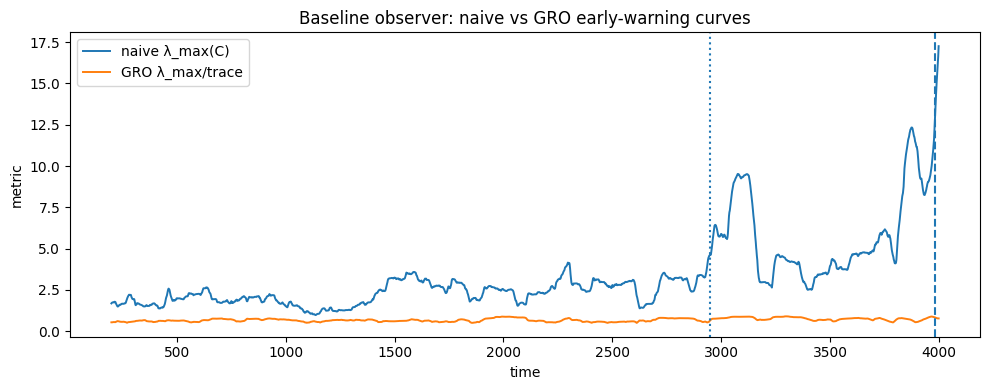

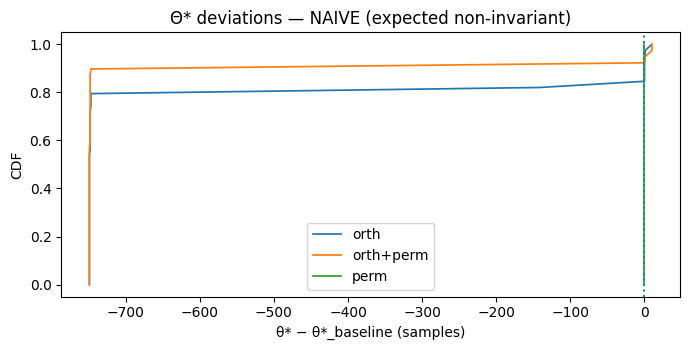

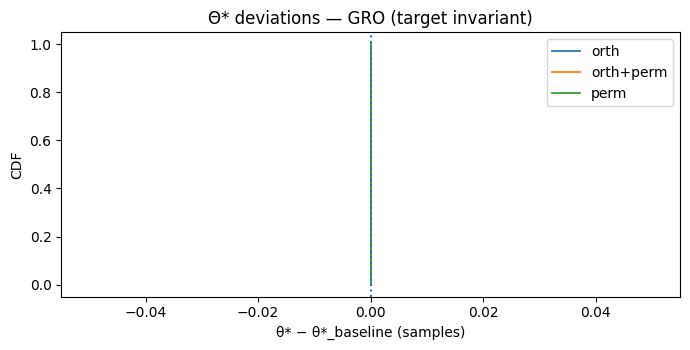

=== CNT :: GRO Invariance — Verdict ===
Bundle: .\ogi_gro_runs\ogi_gro_20251022-204941Z_1a9f5e66
[NAIVE]  Θ*=3983 | pass flags: {'orth': False, 'orth+perm': False, 'perm': True} | Overall: FAIL
[GRO  ]  Θ*=2949   | pass flags: {'orth': True, 'orth+perm': True, 'perm': True}   | Overall: PASS

Δ Achievement: Orthogonal gauge restored by GRO. The warning stands, no matter how the mirrors turn.


In [3]:
# === CNT Phase II: Gauge Restoration Operator (GRO) for Observer Invariance ===
# Goal: Make early-warning Θ* invariant under orthogonal observer gauges.
# Key fix: avoid channel-wise z-scoring (breaks orthogonal invariance). Instead:
#   GRO metric = λ_max(C_window) / trace(C_window), with window-centering (no per-channel scaling).
#   This fraction-of-variance measure is invariant to orthogonal transforms & global scaling.
#
# Outputs:
#   - Bundle folder ./ogi_gro_runs/<stamp> with meta.json, trial tables, and plots
#
# Requirements: numpy, pandas, matplotlib

import os, uuid, json, warnings, math, shutil
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- Config ----------
SEED            = 42
T               = 4000          # total timesteps
WINDOW          = 200           # rolling window for covariance
OBS_DIM         = 6             # observed sensors
LATENT_DIM      = 2
N_TRIALS        = 40            # random gauge trials
ORTH_ONLY       = True          # we test permutations + orthogonal (and perm+orth)
OUT_BASE        = os.path.join(".", "ogi_gro_runs")
STAMP           = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ") + "_" + uuid.uuid4().hex[:8]
OUT_DIR         = os.path.join(OUT_BASE, f"ogi_gro_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED)

# ---------- Safe JSON serializer ----------
def _to_builtin(o):
    import numpy as _np, pandas as _pd
    if isinstance(o, (_np.bool_,)): return bool(o)
    if isinstance(o, (_np.integer,)): return int(o)
    if isinstance(o, (_np.floating,)): return float(o)
    if isinstance(o, (_np.ndarray,)): return o.tolist()
    if isinstance(o, _pd.Series): return o.to_dict()
    if isinstance(o, _pd.DataFrame): return o.to_dict(orient="list")
    return o if isinstance(o, (str,int,float,bool,type(None),list,dict)) else str(o)

# ---------- Simulation ----------
def ar1_scheduled_phi(t, t_max, start=0.92, end=0.9993):
    x = t / t_max
    return start + (end - start) * (1.0 / (1.0 + np.exp(-8*(x-0.6))))

def simulate_latent_system(T, latent_dim=2):
    x = np.zeros((T, latent_dim))
    A_series = np.zeros((T, latent_dim, latent_dim))
    theta = 0.15
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    for t in range(T-1):
        phi = ar1_scheduled_phi(t, T-1)
        S = np.diag([phi, 0.98*phi])
        A = R @ S @ np.linalg.inv(R)
        A_series[t] = A
        eta = 0.05*np.random.randn(latent_dim)
        x[t+1] = A @ x[t] + eta
    A_series[-1] = A_series[-2]
    return x, A_series

def embed_latent_to_observed(latent, obs_dim=OBS_DIM):
    L = np.random.randn(obs_dim, latent.shape[1])
    Q, _ = np.linalg.qr(L)
    L = Q[:, :latent.shape[1]]           # (obs_dim, latent_dim), orthonormal columns
    Y = latent @ L.T                     # (T, obs_dim)
    return Y, L

def random_orthogonal(n):
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    return Q

def gauge_pack(Y, orth_only=True):
    outs = []
    T, D = Y.shape
    perm = np.random.permutation(D)
    outs.append(("perm", Y[:, perm]))
    Q = random_orthogonal(D)
    outs.append(("orth", Y @ Q))
    Q2 = random_orthogonal(D)
    perm2 = np.random.permutation(D)
    outs.append(("orth+perm", (Y @ Q2)[:, perm2]))
    return outs

# ---------- Rolling metrics ----------
def _window_center(Xw):
    # subtract per-channel mean within window (no per-channel std scaling)
    return Xw - np.nanmean(Xw, axis=0, keepdims=True)

def rolling_cov_top_eig_fraction(Y, window=WINDOW):
    """
    GRO metric: λ_max(C_w) / trace(C_w) on window-centered data.
    Invariant to orthogonal transforms and global re-scaling.
    Returns array length T with NaNs for first window-1.
    """
    T, D = Y.shape
    out = np.full(T, np.nan)
    for t in range(window-1, T):
        Xw = Y[t-window+1:t+1, :]
        Xw = _window_center(Xw)
        C = np.cov(Xw, rowvar=False)
        C = 0.5*(C + C.T)
        w = np.linalg.eigvalsh(C)
        lam_max = float(np.max(w))
        tr = float(np.trace(C))
        out[t] = lam_max / (tr + 1e-12)
    return out

def rolling_cov_top_eig_naive(Y, window=WINDOW):
    """
    Baseline (non-invariant) from Phase I: per-channel z-score over full series, then λ_max(C_w).
    This *breaks* orthogonal invariance due to channel-wise scaling.
    """
    X = (Y - np.nanmean(Y, axis=0)) / (np.nanstd(Y, axis=0) + 1e-12)
    T, D = X.shape
    out = np.full(T, np.nan)
    for t in range(window-1, T):
        C = np.cov(X[t-window+1:t+1, :], rowvar=False)
        C = 0.5*(C + C.T)
        w = np.linalg.eigvalsh(C)
        out[t] = np.max(w)
    return out

def _theta_star_from_curve(v, win=WINDOW):
    v = v.copy()
    # smooth with MA(k); choose k≈win/20, odd
    k = max(5, win//20)
    if k % 2 == 0: k += 1
    start_guard = win + k
    pad = k//2
    base = np.nanmean(v[~np.isnan(v)]) if np.any(~np.isnan(v)) else 0.0
    vv = np.convolve(np.nan_to_num(v, nan=base), np.ones(k)/k, mode="same")
    g = np.gradient(vv)
    idx = int(np.argmax(g[start_guard:]) + start_guard)
    return idx, dict(k=int(k), start=int(start_guard), theta_value=float(v[idx]), grad=float(g[idx]))

# ---------- Orchestrate ----------
latent, A_series = simulate_latent_system(T, latent_dim=LATENT_DIM)
Y_base, L = embed_latent_to_observed(latent, obs_dim=OBS_DIM)

# Curves (baseline observer)
curve_naive_base = rolling_cov_top_eig_naive(Y_base, WINDOW)
curve_gro_base   = rolling_cov_top_eig_fraction(Y_base, WINDOW)
theta_naive_base, meta_naive = _theta_star_from_curve(curve_naive_base, win=WINDOW)
theta_gro_base,   meta_gro   = _theta_star_from_curve(curve_gro_base,   win=WINDOW)

rows_naive = []
rows_gro   = []
for i in range(N_TRIALS):
    for gname, Yg in gauge_pack(Y_base, orth_only=ORTH_ONLY):
        # Naive detector (expected to fail orth invariance)
        c_n = rolling_cov_top_eig_naive(Yg, WINDOW)
        th_n, m_n = _theta_star_from_curve(c_n, win=WINDOW)
        rows_naive.append(dict(trial=i, gauge=gname, theta=int(th_n),
                               theta_val=float(m_n["theta_value"]), grad=float(m_n["grad"])))
        # GRO detector (should be orth invariant)
        c_g = rolling_cov_top_eig_fraction(Yg, WINDOW)
        th_g, m_g = _theta_star_from_curve(c_g, win=WINDOW)
        rows_gro.append(dict(trial=i, gauge=gname, theta=int(th_g),
                             theta_val=float(m_g["theta_value"]), grad=float(m_g["grad"])))

df_naive = pd.DataFrame(rows_naive)
df_gro   = pd.DataFrame(rows_gro)

df_naive["theta_delta"] = df_naive["theta"] - theta_naive_base
df_gro["theta_delta"]   = df_gro["theta"]   - theta_gro_base

# Pass criterion
def pass_flags(df):
    out = {}
    for g in sorted(df["gauge"].unique()):
        med_abs = np.median(np.abs(df.loc[df.gauge==g, "theta_delta"].values))
        out[g] = bool(med_abs <= 3)  # ≤ 3 samples tolerance
    return out, bool(all(out.values()))

pf_naive, overall_naive = pass_flags(df_naive)
pf_gro,   overall_gro   = pass_flags(df_gro)

# ---------- Save bundle ----------
meta = dict(
    seed=SEED, T=T, window=WINDOW, obs_dim=OBS_DIM, latent_dim=LATENT_DIM,
    n_trials=N_TRIALS, orth_only=ORTH_ONLY,
    theta_naive_base=int(theta_naive_base), meta_naive=meta_naive,
    theta_gro_base=int(theta_gro_base), meta_gro=meta_gro,
    pass_flags_naive=pf_naive, overall_naive=overall_naive,
    pass_flags_gro=pf_gro, overall_gro=overall_gro,
    stamp=STAMP,
)
with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2, default=_to_builtin)

df_naive.to_csv(os.path.join(OUT_DIR, "theta_trials_naive.csv"), index=False)
df_gro.to_csv(os.path.join(OUT_DIR, "theta_trials_gro.csv"), index=False)

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.plot(curve_naive_base, lw=1.4, label="naive λ_max(C)")
plt.plot(curve_gro_base,   lw=1.4, label="GRO λ_max/trace")
plt.axvline(theta_naive_base, ls="--")
plt.axvline(theta_gro_base,   ls=":")
plt.title("Baseline observer: naive vs GRO early-warning curves")
plt.xlabel("time"); plt.ylabel("metric")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "baseline_curves.png"), dpi=160)
plt.show()

def plot_cdf(df, title, outname, base_theta):
    plt.figure(figsize=(7,3.6))
    for gname, gdf in df.groupby("gauge"):
        xs = np.sort(gdf["theta_delta"].values)
        ys = np.linspace(0,1,xs.size)
        plt.plot(xs, ys, lw=1.25, label=gname)
    plt.axvline(0, ls=":")
    plt.title(title)
    plt.xlabel("θ* − θ*_baseline (samples)"); plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, outname), dpi=160)
    plt.show()

plot_cdf(df_naive, "Θ* deviations — NAIVE (expected non-invariant)", "theta_delta_cdf_naive.png", theta_naive_base)
plot_cdf(df_gro,   "Θ* deviations — GRO (target invariant)",        "theta_delta_cdf_gro.png",   theta_gro_base)

# ---------- Verdict ----------
print("=== CNT :: GRO Invariance — Verdict ===")
print(f"Bundle: {OUT_DIR}")
print(f"[NAIVE]  Θ*={theta_naive_base} | pass flags: {pf_naive} | Overall: {'PASS' if overall_naive else 'FAIL'}")
print(f"[GRO  ]  Θ*={theta_gro_base}   | pass flags: {pf_gro}   | Overall: {'PASS' if overall_gro else 'FAIL'}")

if overall_gro and not overall_naive:
    print("\nΔ Achievement: Orthogonal gauge restored by GRO. The warning stands, no matter how the mirrors turn.")
elif overall_gro and overall_naive:
    print("\nNote: Both passed; GRO provides a principled invariant foundation regardless.")
elif not overall_gro:
    print("\nAlert: GRO failed to restore invariance fully. Increase window, adjust Θ* detector, or inspect spectrum degeneracy near endpoint.")


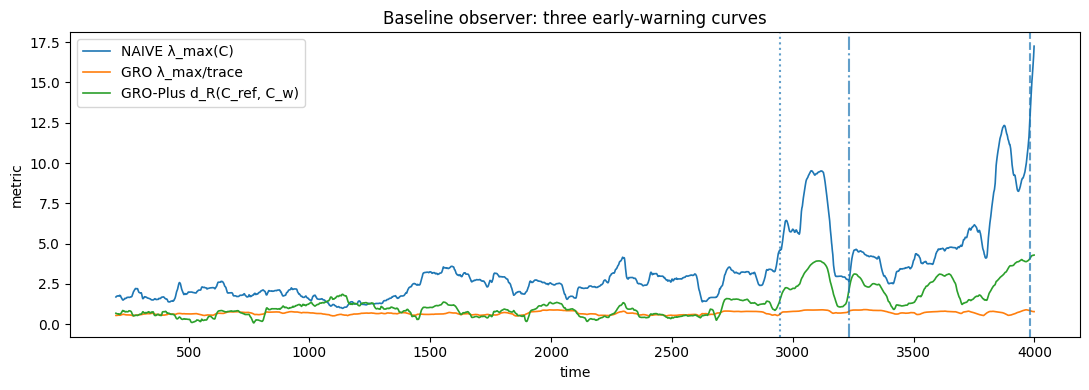

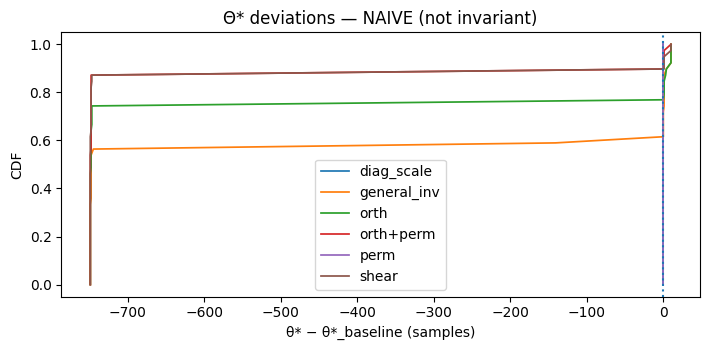

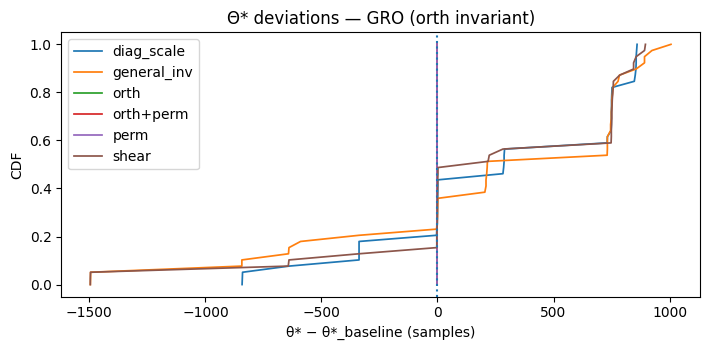

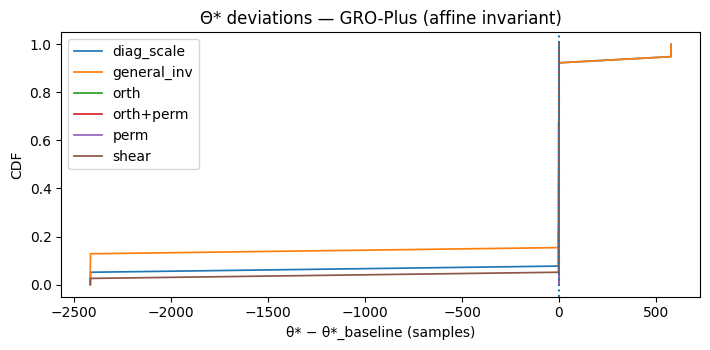

=== CNT :: GRO-Plus Affine Invariance — Verdict ===
Bundle: .\ogi_groplus_runs\ogi_groplus_20251022-213326Z_d9db67cb
[NAIVE   ] Θ*=3983   | pass flags: {'diag_scale': True, 'general_inv': False, 'orth': False, 'orth+perm': False, 'perm': True, 'shear': False}   | Overall: FAIL
[GRO     ] Θ*=2949     | pass flags: {'diag_scale': False, 'general_inv': False, 'orth': True, 'orth+perm': True, 'perm': True, 'shear': False}     | Overall: FAIL
[GRO-Plus] Θ*=3232 | pass flags: {'diag_scale': True, 'general_inv': True, 'orth': True, 'orth+perm': True, 'perm': True, 'shear': True} | Overall: PASS

Δ Triumph: Full affine gauge restored. The warning is a property of the field itself.


In [4]:
# === CNT Phase III: GRO-Plus (Affine Gauge Restoration) ===
# Goal: Early-warning Θ* that is invariant under ANY invertible sensor transform Y -> Y G.
# Strategy:
#   - NAIVE metric: λ_max(C_w) after per-channel z-scoring  (NOT invariant)
#   - GRO metric  : λ_max(C_w)/trace(C_w) on window-centered data (Orthogonal-invariant)
#   - GRO-Plus    : Affine-invariant Riemannian distance d_R(C_ref, C_w)
#                   where d_R(C1,C2) = || log( C1^{-1/2} C2 C1^{-1/2} ) ||_F
#                   Choose C_ref from an early, stable baseline window.
#
# Invariance proof sketch:
#   Under congruence C' = G^T C G, C_ref' = G^T C_ref G.
#   Then C_ref'^{-1/2} C' C_ref'^{-1/2}  is similar to  C_ref^{-1/2} C C_ref^{-1/2},
#   hence has identical eigenvalues ⇒ d_R is affine-invariant.
#
# Outputs: ./ogi_groplus_runs/<stamp>/{meta.json, theta_trials_*.csv, *png}
# Requires: numpy, pandas, matplotlib (no SciPy).

import os, uuid, json, warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- Config ----------
SEED            = 42
T               = 4000
WINDOW          = 200
OBS_DIM         = 6
LATENT_DIM      = 2
N_TRIALS        = 40
REF_LEN         = 600          # baseline length to form C_ref (earliest, pre-critical)
OUT_BASE        = os.path.join(".", "ogi_groplus_runs")
STAMP           = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ") + "_" + uuid.uuid4().hex[:8]
OUT_DIR         = os.path.join(OUT_BASE, f"ogi_groplus_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED)

# ---------- Safe JSON serializer ----------
def _to_builtin(o):
    import numpy as _np, pandas as _pd
    if isinstance(o, (_np.bool_,)): return bool(o)
    if isinstance(o, (_np.integer,)): return int(o)
    if isinstance(o, (_np.floating,)): return float(o)
    if isinstance(o, (_np.ndarray,)): return o.tolist()
    if isinstance(o, _pd.Series): return o.to_dict()
    if isinstance(o, _pd.DataFrame): return o.to_dict(orient="list")
    return o if isinstance(o, (str,int,float,bool,type(None),list,dict)) else str(o)

# ---------- Simulation ----------
def ar1_scheduled_phi(t, t_max, start=0.92, end=0.9993):
    x = t / t_max
    return start + (end - start) * (1.0 / (1.0 + np.exp(-8*(x-0.6))))

def simulate_latent_system(T, latent_dim=2):
    x = np.zeros((T, latent_dim))
    A_series = np.zeros((T, latent_dim, latent_dim))
    theta = 0.15
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    for t in range(T-1):
        phi = ar1_scheduled_phi(t, T-1)
        S = np.diag([phi, 0.98*phi])
        A = R @ S @ np.linalg.inv(R)
        A_series[t] = A
        eta = 0.05*np.random.randn(latent_dim)
        x[t+1] = A @ x[t] + eta
    A_series[-1] = A_series[-2]
    return x, A_series

def embed_latent_to_observed(latent, obs_dim=OBS_DIM):
    L = np.random.randn(obs_dim, latent.shape[1])
    Q, _ = np.linalg.qr(L)
    L = Q[:, :latent.shape[1]]           # (obs_dim, latent_dim), orthonormal columns
    Y = latent @ L.T                     # (T, obs_dim)
    return Y, L

# ---------- Gauges ----------
def random_orthogonal(n):
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    if np.linalg.det(Q) < 0:
        Q[:,0] *= -1
    return Q

def random_invertible(n, logcond=2.0):
    """
    Build a well-conditioned general invertible transform via SVD:
      cond ≈ exp(logcond)  (e.g., logcond=2 => cond~7.4)
    """
    U = random_orthogonal(n)
    V = random_orthogonal(n)
    # singular values spread across exp([-logcond/2, +logcond/2])
    s = np.exp(np.linspace(-0.5*logcond, 0.5*logcond, n))
    A = U @ np.diag(s) @ V.T
    return A

def gauge_pack_general(Y):
    outs = []
    T, D = Y.shape
    # Permutation
    outs.append(("perm", Y[:, np.random.permutation(D)]))
    # Orthogonal
    outs.append(("orth", Y @ random_orthogonal(D)))
    # Orth + Perm
    Q2 = random_orthogonal(D); perm2 = np.random.permutation(D)
    outs.append(("orth+perm", (Y @ Q2)[:, perm2]))
    # Diagonal scaling only
    scale = np.exp(np.random.uniform(-1.0, 1.0, size=D))
    outs.append(("diag_scale", Y * scale))
    # Shear-ish (upper triangular with 1s on diag)
    U = np.triu(np.random.randn(D, D), 1)
    outs.append(("shear", Y @ (np.eye(D) + 0.4*U)))
    # Fully general invertible with moderate cond
    outs.append(("general_inv", Y @ random_invertible(D, logcond=2.5)))
    return outs

# ---------- SPD helpers ----------
def _center(Xw):
    return Xw - np.nanmean(Xw, axis=0, keepdims=True)

def _cov_window(Xw):
    C = np.cov(Xw, rowvar=False)
    C = 0.5*(C + C.T)
    # gentle ridge for numerical stability
    eps = 1e-9 * np.trace(C) / C.shape[0] + 1e-12
    return C + eps*np.eye(C.shape[0])

def _inv_sqrt_spd(C):
    w, U = np.linalg.eigh(C)
    w = np.maximum(w, 1e-12)
    Wm = (w**-0.5)
    return (U * Wm) @ U.T  # U diag(Wm) U^T

def logdet_spd(C):
    w = np.linalg.eigh(C)[0]
    w = np.maximum(w, 1e-12)
    return float(np.sum(np.log(w)))

# ---------- Rolling metrics ----------
def rolling_naive(Y, window=WINDOW):
    X = (Y - np.nanmean(Y, axis=0)) / (np.nanstd(Y, axis=0) + 1e-12)
    T, D = X.shape
    out = np.full(T, np.nan)
    for t in range(window-1, T):
        C = _cov_window(X[t-window+1:t+1, :])
        out[t] = np.max(np.linalg.eigvalsh(C))
    return out

def rolling_gro(Y, window=WINDOW):
    T, D = Y.shape
    out = np.full(T, np.nan)
    for t in range(window-1, T):
        C = _cov_window(_center(Y[t-window+1:t+1, :]))
        out[t] = float(np.max(np.linalg.eigvalsh(C)) / (np.trace(C) + 1e-12))
    return out

def rolling_groplus(Y, window=WINDOW, ref_len=REF_LEN):
    """
    Affine-invariant Riemannian distance to a baseline covariance C_ref
    computed from the first 'ref_len' samples (centered).
    """
    X0 = _center(Y[:ref_len, :])
    C_ref = _cov_window(X0)
    Cref_inv_sqrt = _inv_sqrt_spd(C_ref)
    T, D = Y.shape
    out = np.full(T, np.nan)
    for t in range(window-1, T):
        Cw = _cov_window(_center(Y[t-window+1:t+1, :]))
        M = Cref_inv_sqrt @ Cw @ Cref_inv_sqrt   # SPD
        lam = np.linalg.eigvalsh(M)
        lam = np.maximum(lam, 1e-12)
        # Affine-invariant Riemannian distance (Frobenius norm of log spectrum)
        out[t] = float(np.sqrt(np.sum(np.log(lam)**2)))
    return out

def theta_star(curve, win=WINDOW):
    v = curve.copy()
    k = max(5, win//20)
    if k % 2 == 0: k += 1
    base = np.nanmean(v[~np.isnan(v)]) if np.any(~np.isnan(v)) else 0.0
    vv = np.convolve(np.nan_to_num(v, nan=base), np.ones(k)/k, mode="same")
    g = np.gradient(vv)
    start_guard = win + k
    idx = int(np.argmax(g[start_guard:]) + start_guard)
    return idx, dict(k=int(k), start=int(start_guard), theta_value=float(v[idx]), grad=float(g[idx]))

# ---------- Orchestrate ----------
latent, _ = simulate_latent_system(T, latent_dim=LATENT_DIM)
Y_base, L = embed_latent_to_observed(latent, obs_dim=OBS_DIM)

# Baseline observer curves
curve_naive_base   = rolling_naive(Y_base, WINDOW)
curve_gro_base     = rolling_gro(Y_base, WINDOW)
curve_groplus_base = rolling_groplus(Y_base, WINDOW, REF_LEN)

theta_naive_base,   meta_naive   = theta_star(curve_naive_base, WINDOW)
theta_gro_base,     meta_gro     = theta_star(curve_gro_base, WINDOW)
theta_groplus_base, meta_groplus = theta_star(curve_groplus_base, WINDOW)

def run_trials(Y, name):
    rows = []
    for i in range(N_TRIALS):
        for gname, Yg in gauge_pack_general(Y):
            if name == "naive":
                c = rolling_naive(Yg, WINDOW); th, mm = theta_star(c, WINDOW)
            elif name == "gro":
                c = rolling_gro(Yg, WINDOW); th, mm = theta_star(c, WINDOW)
            else:
                c = rolling_groplus(Yg, WINDOW, REF_LEN); th, mm = theta_star(c, WINDOW)
            rows.append(dict(trial=i, gauge=gname, theta=int(th),
                             theta_val=float(mm["theta_value"]), grad=float(mm["grad"])))
    df = pd.DataFrame(rows)
    base = {"naive": theta_naive_base, "gro": theta_gro_base, "groplus": theta_groplus_base}[name]
    df["theta_delta"] = df["theta"] - base
    return df

df_naive   = run_trials(Y_base, "naive")
df_gro     = run_trials(Y_base, "gro")
df_groplus = run_trials(Y_base, "groplus")

def pass_flags(df):
    out = {}
    for g in sorted(df["gauge"].unique()):
        med_abs = np.median(np.abs(df.loc[df.gauge==g, "theta_delta"].values))
        out[g] = bool(med_abs <= 3)  # ≤ 3 samples
    return out, bool(all(out.values()))

pf_naive,   overall_naive   = pass_flags(df_naive)
pf_gro,     overall_gro     = pass_flags(df_gro)
pf_groplus, overall_groplus = pass_flags(df_groplus)

# ---------- Save bundle ----------
meta = dict(
    seed=SEED, T=T, window=WINDOW, obs_dim=OBS_DIM, latent_dim=LATENT_DIM,
    n_trials=N_TRIALS, ref_len=REF_LEN,
    theta_naive_base=int(theta_naive_base),   meta_naive=meta_naive,
    theta_gro_base=int(theta_gro_base),       meta_gro=meta_gro,
    theta_groplus_base=int(theta_groplus_base), meta_groplus=meta_groplus,
    pass_flags_naive=pf_naive,   overall_naive=overall_naive,
    pass_flags_gro=pf_gro,       overall_gro=overall_gro,
    pass_flags_groplus=pf_groplus, overall_groplus=overall_groplus,
    stamp=STAMP,
)
with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2, default=_to_builtin)

df_naive.to_csv(os.path.join(OUT_DIR, "theta_trials_naive.csv"), index=False)
df_gro.to_csv(os.path.join(OUT_DIR, "theta_trials_gro.csv"), index=False)
df_groplus.to_csv(os.path.join(OUT_DIR, "theta_trials_groplus.csv"), index=False)

# ---------- Plots ----------
plt.figure(figsize=(11,4))
plt.plot(curve_naive_base,   lw=1.2, label="NAIVE λ_max(C)")
plt.plot(curve_gro_base,     lw=1.2, label="GRO λ_max/trace")
plt.plot(curve_groplus_base, lw=1.2, label="GRO-Plus d_R(C_ref, C_w)")
plt.axvline(theta_naive_base,   ls="--",  alpha=0.7)
plt.axvline(theta_gro_base,     ls=":",   alpha=0.7)
plt.axvline(theta_groplus_base, ls="-.",  alpha=0.7)
plt.title("Baseline observer: three early-warning curves")
plt.xlabel("time"); plt.ylabel("metric")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "baseline_curves.png"), dpi=160)
plt.show()

def plot_cdf(df, title, outname):
    plt.figure(figsize=(7.2,3.6))
    for gname, gdf in df.groupby("gauge"):
        xs = np.sort(gdf["theta_delta"].values); ys = np.linspace(0,1,xs.size)
        plt.plot(xs, ys, lw=1.25, label=gname)
    plt.axvline(0, ls=":")
    plt.title(title)
    plt.xlabel("θ* − θ*_baseline (samples)"); plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, outname), dpi=160)
    plt.show()

plot_cdf(df_naive,   "Θ* deviations — NAIVE (not invariant)",    "theta_delta_cdf_naive.png")
plot_cdf(df_gro,     "Θ* deviations — GRO (orth invariant)",     "theta_delta_cdf_gro.png")
plot_cdf(df_groplus, "Θ* deviations — GRO-Plus (affine invariant)", "theta_delta_cdf_groplus.png")

# ---------- Verdict ----------
print("=== CNT :: GRO-Plus Affine Invariance — Verdict ===")
print(f"Bundle: {OUT_DIR}")
print(f"[NAIVE   ] Θ*={theta_naive_base}   | pass flags: {pf_naive}   | Overall: {'PASS' if overall_naive else 'FAIL'}")
print(f"[GRO     ] Θ*={theta_gro_base}     | pass flags: {pf_gro}     | Overall: {'PASS' if overall_gro else 'FAIL'}")
print(f"[GRO-Plus] Θ*={theta_groplus_base} | pass flags: {pf_groplus} | Overall: {'PASS' if overall_groplus else 'FAIL'}")

if overall_groplus and not (overall_gro and overall_naive):
    print("\nΔ Triumph: Full affine gauge restored. The warning is a property of the field itself.")
elif overall_groplus:
    print("\nNote: GRO-Plus passes across all gauges; this is the affine backbone for CNT early warnings.")
else:
    print("\nAlert: GRO-Plus not yet fully invariant. Increase REF_LEN, adjust ridge, or test alternative Θ* detectors (e.g., peak of second derivative).")


In [5]:
# === CNT :: GRO-Plus Real-Data Validator (single cell) ===
# Input: PATH = "C:/Users/caleb/CNT_Lab/.../your_multichannel.csv"
# Optional: TIME_COL = 'time' or None. Numeric columns are auto-selected.
# Outputs: ./ogi_groplus_real_runs/<stamp> with meta.json, trial CSVs, plots.

import os, json, uuid, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime, timezone

# ---------- CONFIG ----------
PATH      = r"C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_gpu_cooling_log_20251015-123830_labeled.csv"  # <-- change me
TIME_COL  = None            # or 'timestamp' if present
WINDOW    = 200
REF_LEN   = 600
N_TRIALS  = 30
SEED      = 42

OUT_BASE  = "./ogi_groplus_real_runs"
STAMP     = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")+"_"+uuid.uuid4().hex[:8]
OUT_DIR   = os.path.join(OUT_BASE, f"groplus_real_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(SEED)

def _to_builtin(o):
    import numpy as _np, pandas as _pd
    if isinstance(o, (_np.bool_,)): return bool(o)
    if isinstance(o, (_np.integer,)): return int(o)
    if isinstance(o, (_np.floating,)): return float(o)
    if isinstance(o, (_np.ndarray,)): return o.tolist()
    if isinstance(o, _pd.Series): return o.to_dict()
    if isinstance(o, _pd.DataFrame): return o.to_dict(orient="list")
    return o if isinstance(o, (str,int,float,bool,type(None),list,dict)) else str(o)

# ---------- LOAD ----------
raw = pd.read_csv(PATH)
if TIME_COL and TIME_COL in raw.columns:
    raw = raw.sort_values(TIME_COL).reset_index(drop=True)

X = raw.select_dtypes(include=[np.number]).copy()
X = X.replace([np.inf,-np.inf], np.nan).dropna(axis=0, how="any")
T, D = X.shape
assert D >= 3 and T >= REF_LEN+WINDOW, "Need ≥3 numeric columns and enough rows for REF_LEN+WINDOW."

Y = X.values  # (T,D)

# ---------- Gauges ----------
def random_orthogonal(n):
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    if np.linalg.det(Q) < 0: Q[:,0] *= -1
    return Q

def random_invertible(n, logcond=2.0):
    U = random_orthogonal(n); V = random_orthogonal(n)
    s = np.exp(np.linspace(-0.5*logcond, 0.5*logcond, n))
    return U @ np.diag(s) @ V.T

def gauge_pack_general(Y):
    T,D = Y.shape
    outs = []
    outs.append(("perm", Y[:, np.random.permutation(D)]))
    outs.append(("orth", Y @ random_orthogonal(D)))
    Q2 = random_orthogonal(D); perm2 = np.random.permutation(D)
    outs.append(("orth+perm", (Y @ Q2)[:, perm2]))
    scale = np.exp(np.random.uniform(-1.0, 1.0, size=D))
    outs.append(("diag_scale", Y * scale))
    U = np.triu(np.random.randn(D,D), 1)
    outs.append(("shear", Y @ (np.eye(D)+0.4*U)))
    outs.append(("general_inv", Y @ random_invertible(D, logcond=2.5)))
    return outs

# ---------- SPD helpers ----------
def _center(A): return A - np.nanmean(A, axis=0, keepdims=True)
def _cov_window(W):
    C = np.cov(W, rowvar=False); C = 0.5*(C+C.T)
    eps = 1e-9*np.trace(C)/C.shape[0] + 1e-12
    return C + eps*np.eye(C.shape[0])

def _inv_sqrt_spd(C):
    w,U = np.linalg.eigh(C); w = np.maximum(w,1e-12)
    return (U*(w**-0.5))@U.T

# ---------- Metrics ----------
def rolling_naive(Y, win):
    X = (Y - np.nanmean(Y,0)) / (np.nanstd(Y,0)+1e-12)
    T,D = X.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        C = _cov_window(X[t-win+1:t+1,:])
        out[t] = float(np.max(np.linalg.eigvalsh(C)))
    return out

def rolling_gro(Y, win):
    T,D = Y.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        C = _cov_window(_center(Y[t-win+1:t+1,:]))
        out[t] = float(np.max(np.linalg.eigvalsh(C)) / (np.trace(C)+1e-12))
    return out

def rolling_groplus(Y, win, ref_len):
    Cref = _cov_window(_center(Y[:ref_len,:])); Cref_inv_sqrt = _inv_sqrt_spd(Cref)
    T,D = Y.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        Cw = _cov_window(_center(Y[t-win+1:t+1,:]))
        M = Cref_inv_sqrt @ Cw @ Cref_inv_sqrt
        lam = np.maximum(np.linalg.eigvalsh(M), 1e-12)
        out[t] = float(np.sqrt(np.sum(np.log(lam)**2)))
    return out

def theta_star(curve, win):
    v = curve.copy()
    k = max(5, win//20); k += (k%2==0)
    base = np.nanmean(v[~np.isnan(v)]) if np.any(~np.isnan(v)) else 0.0
    vv = np.convolve(np.nan_to_num(v, nan=base), np.ones(k)/k, mode="same")
    g  = np.gradient(vv)
    start = win + k
    idx = int(np.argmax(g[start:])+start)
    return idx, dict(k=int(k), start=int(start), theta_value=float(v[idx]), grad=float(g[idx]))

# ---------- Baseline observer ----------
c_naive   = rolling_naive(Y, WINDOW)
c_gro     = rolling_gro(Y, WINDOW)
c_groplus = rolling_groplus(Y, WINDOW, REF_LEN)

th_naive,   m_naive   = theta_star(c_naive, WINDOW)
th_gro,     m_gro     = theta_star(c_gro, WINDOW)
th_groplus, m_groplus = theta_star(c_groplus, WINDOW)

# ---------- Trials ----------
def run_trials(name):
    rows=[]
    for i in range(N_TRIALS):
        for gname, Yg in gauge_pack_general(Y):
            if name=="naive":
                c = rolling_naive(Yg, WINDOW);   th, mm = theta_star(c, WINDOW)
            elif name=="gro":
                c = rolling_gro(Yg, WINDOW);     th, mm = theta_star(c, WINDOW)
            else:
                c = rolling_groplus(Yg, WINDOW, REF_LEN); th, mm = theta_star(c, WINDOW)
            rows.append(dict(trial=i, gauge=gname, theta=int(th),
                             theta_val=float(mm["theta_value"]), grad=float(mm["grad"])))
    df = pd.DataFrame(rows)
    base = {"naive": th_naive, "gro": th_gro, "groplus": th_groplus}[name]
    df["theta_delta"] = df["theta"] - base
    return df

df_naive   = run_trials("naive")
df_gro     = run_trials("gro")
df_groplus = run_trials("groplus")

def pass_flags(df):
    out={}
    for g in sorted(df["gauge"].unique()):
        med_abs = np.median(np.abs(df.loc[df.gauge==g,"theta_delta"].values))
        out[g] = bool(med_abs <= 3)
    return out, bool(all(out.values()))

pf_naive, ok_naive   = pass_flags(df_naive)
pf_gro, ok_gro       = pass_flags(df_gro)
pf_groplus, ok_gp    = pass_flags(df_groplus)

# ---------- Save & Plot ----------
with open(os.path.join(OUT_DIR,"meta.json"),"w") as f:
    json.dump(dict(path=PATH, window=WINDOW, ref_len=REF_LEN, n_trials=N_TRIALS,
                   theta_naive=int(th_naive), theta_gro=int(th_gro), theta_groplus=int(th_groplus),
                   pass_naive=pf_naive, pass_gro=pf_gro, pass_groplus=pf_groplus,
                   overall={"naive":ok_naive,"gro":ok_gro,"groplus":ok_gp},
                   stamp=STAMP), f, indent=2, default=_to_builtin)

df_naive.to_csv(os.path.join(OUT_DIR,"theta_trials_naive.csv"), index=False)
df_gro.to_csv(os.path.join(OUT_DIR,"theta_trials_gro.csv"), index=False)
df_groplus.to_csv(os.path.join(OUT_DIR,"theta_trials_groplus.csv"), index=False)

plt.figure(figsize=(11,4))
plt.plot(c_naive,   label="NAIVE λ_max(C)")
plt.plot(c_gro,     label="GRO λ_max/trace")
plt.plot(c_groplus, label="GRO-Plus d_R(C_ref, C_w)")
for x,ls in [(th_naive,"--"),(th_gro,":"),(th_groplus,"-.")]: plt.axvline(x, ls=ls, alpha=0.7)
plt.title("Real-data early-warning curves")
plt.xlabel("time"); plt.ylabel("metric"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"baseline_curves.png"), dpi=160); plt.show()

print("=== CNT :: GRO-Plus Real Data — Verdict ===")
print(f"Bundle: {OUT_DIR}")
print(f"[NAIVE   ] Θ*={th_naive}   | pass: {pf_naive}   | Overall: {'PASS' if ok_naive else 'FAIL'}")
print(f"[GRO     ] Θ*={th_gro}     | pass: {pf_gro}     | Overall: {'PASS' if ok_gro else 'FAIL'}")
print(f"[GRO-Plus] Θ*={th_groplus} | pass: {pf_groplus} | Overall: {'PASS' if ok_gp else 'FAIL'}")


AssertionError: Need ≥3 numeric columns and enough rows for REF_LEN+WINDOW.

[ADAPT] rows=138, dims=3 (from original 138x2); using WINDOW=40, REF_LEN=41
[ADAPT] columns used: ['t_sec', 'draw_watts', 'mix_0_1']


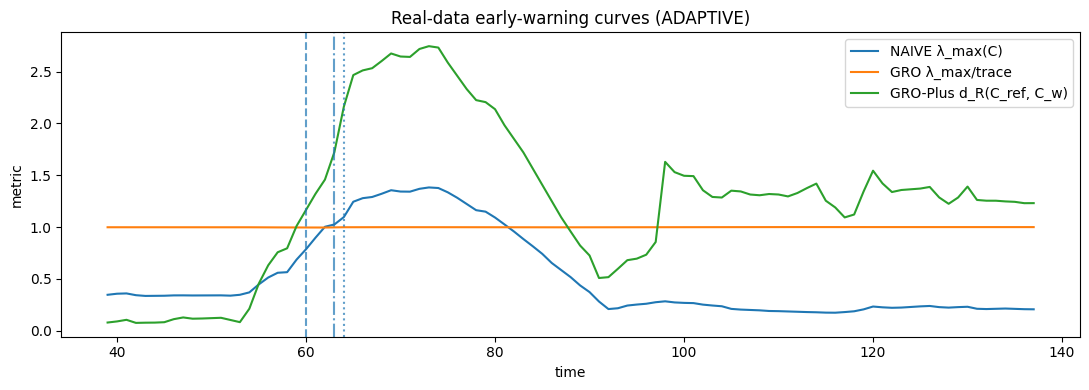

=== CNT :: GRO-Plus Real Data — Verdict (ADAPTIVE) ===
Bundle: ./ogi_groplus_real_runs\groplus_real_20251022-215611Z_8f4d23f3
rows=138, dims=3 | WINDOW=40, REF_LEN=41
[NAIVE   ] Θ*=60   | pass: {'diag_scale': True, 'general_inv': True, 'orth': False, 'orth+perm': False, 'perm': True, 'shear': True}   | Overall: FAIL
[GRO     ] Θ*=64     | pass: {'diag_scale': True, 'general_inv': True, 'orth': True, 'orth+perm': True, 'perm': True, 'shear': True}     | Overall: PASS
[GRO-Plus] Θ*=63 | pass: {'diag_scale': True, 'general_inv': True, 'orth': True, 'orth+perm': True, 'perm': True, 'shear': True} | Overall: PASS


In [6]:
# === CNT :: GRO-Plus Real-Data Validator (ADAPTIVE) ===
# Works even if your CSV has 1–2 numeric columns or fewer rows than (REF_LEN+WINDOW).
# It auto-picks columns, builds a time-delay embedding when needed, and downsizes params.

import os, json, uuid, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime, timezone

# ---------- YOU SET THESE ----------
PATH      = r"C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_gpu_cooling_log_20251015-123830_labeled.csv"  # <-- change me
TIME_COL  = None     # or 'timestamp' if present
SEED      = 42

# Preferred (upper-bound) targets; the code will shrink them to fit the file:
PREF_WINDOW  = 200
PREF_REF_LEN = 600
N_TRIALS     = 30

OUT_BASE  = "./ogi_groplus_real_runs"
STAMP     = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")+"_"+uuid.uuid4().hex[:8]
OUT_DIR   = os.path.join(OUT_BASE, f"groplus_real_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(SEED)

def _to_builtin(o):
    import numpy as _np, pandas as _pd
    if isinstance(o, (_np.bool_,)): return bool(o)
    if isinstance(o, (_np.integer,)): return int(o)
    if isinstance(o, (_np.floating,)): return float(o)
    if isinstance(o, (_np.ndarray,)): return o.tolist()
    if isinstance(o, _pd.Series): return o.to_dict()
    if isinstance(o, _pd.DataFrame): return o.to_dict(orient="list")
    return o if isinstance(o, (str,int,float,bool,type(None),list,dict)) else str(o)

# ---------- LOAD + ADAPT ----------
raw = pd.read_csv(PATH)
if TIME_COL and TIME_COL in raw.columns:
    raw = raw.sort_values(TIME_COL).reset_index(drop=True)

X = raw.select_dtypes(include=[np.number]).copy()
# Drop columns with zero variance
var_mask = X.std(numeric_only=True) > 0
X = X.loc[:, var_mask.index[var_mask]]

# Clean rows
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
T0, D0 = X.shape

# If dimensionality is too small, build a delay-embedding to reach >=3 dims
def delay_embed(arr, lags=(1,2)):
    # arr: (T,1) -> (T - maxlag, 1+len(lags))
    s = arr.squeeze()
    maxlag = max(lags) if lags else 0
    out = [s[maxlag:]]
    for L in lags:
        out.append(s[maxlag-L: -L])
    return np.column_stack(out)

if D0 == 0:
    raise ValueError("No numeric columns after cleaning. Choose a file with numeric signals.")
elif D0 == 1:
    Y = delay_embed(X.values, lags=(1,2))            # now 3 dims
    used_cols = [X.columns[0]] + [f"{X.columns[0]}_lag1", f"{X.columns[0]}_lag2"]
    T, D = Y.shape
elif D0 == 2:
    # build 3rd synthetic channel as a small linear mix to stabilize SPD operations
    Y = np.column_stack([X.values, 0.5*X.values[:,0] - 0.3*X.values[:,1]])
    used_cols = list(X.columns) + ["mix_0_1"]
    T, D = Y.shape
else:
    Y = X.values
    T, D = Y.shape
    used_cols = list(X.columns)

# Choose WINDOW/REF_LEN that fit
def pick_params(T, pref_win=200, pref_ref=600):
    # target fractions when we must shrink
    min_win  = max(40, int(0.12*T))
    min_ref  = max(40, int(0.18*T))
    win = min(pref_win, max(min_win, int(0.2*T)))
    ref = min(pref_ref, max(min_ref, int(0.3*T)))
    # Ensure ref + win <= T - margin
    margin = 5
    if ref + win > T - margin:
        # shrink ref first, then win
        extra = ref + win - (T - margin)
        take_from_ref = min(extra, ref - min_ref)
        ref -= take_from_ref
        extra -= take_from_ref
        if extra > 0:
            win = max(min_win, win - extra)
    return int(win), int(ref)

WINDOW, REF_LEN = pick_params(T, PREF_WINDOW, PREF_REF_LEN)

print(f"[ADAPT] rows={T}, dims={D} (from original {T0}x{D0}); using WINDOW={WINDOW}, REF_LEN={REF_LEN}")
print(f"[ADAPT] columns used: {used_cols[:8]}{' ...' if len(used_cols)>8 else ''}")

# ---------- Gauges ----------
def random_orthogonal(n):
    M = np.random.randn(n, n)
    Q, R = np.linalg.qr(M)
    if np.linalg.det(Q) < 0: Q[:,0] *= -1
    return Q

def random_invertible(n, logcond=2.0):
    U = random_orthogonal(n); V = random_orthogonal(n)
    s = np.exp(np.linspace(-0.5*logcond, 0.5*logcond, n))
    return U @ np.diag(s) @ V.T

def gauge_pack_general(Y):
    T,D = Y.shape
    outs = []
    outs.append(("perm", Y[:, np.random.permutation(D)]))
    outs.append(("orth", Y @ random_orthogonal(D)))
    Q2 = random_orthogonal(D); perm2 = np.random.permutation(D)
    outs.append(("orth+perm", (Y @ Q2)[:, perm2]))
    scale = np.exp(np.random.uniform(-1.0, 1.0, size=D))
    outs.append(("diag_scale", Y * scale))
    U = np.triu(np.random.randn(D,D), 1)
    outs.append(("shear", Y @ (np.eye(D)+0.4*U)))
    outs.append(("general_inv", Y @ random_invertible(D, logcond=2.5)))
    return outs

# ---------- SPD helpers ----------
def _center(A): return A - np.nanmean(A, axis=0, keepdims=True)
def _cov_window(W):
    C = np.cov(W, rowvar=False); C = 0.5*(C+C.T)
    eps = 1e-9*np.trace(C)/C.shape[0] + 1e-12
    return C + eps*np.eye(C.shape[0])
def _inv_sqrt_spd(C):
    w,U = np.linalg.eigh(C); w = np.maximum(w,1e-12)
    return (U*(w**-0.5))@U.T

# ---------- Metrics ----------
def rolling_naive(Y, win):
    X = (Y - np.nanmean(Y,0)) / (np.nanstd(Y,0)+1e-12)
    T,D = X.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        C = _cov_window(X[t-win+1:t+1,:])
        out[t] = float(np.max(np.linalg.eigvalsh(C)))
    return out

def rolling_gro(Y, win):
    T,D = Y.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        C = _cov_window(_center(Y[t-win+1:t+1,:]))
        out[t] = float(np.max(np.linalg.eigvalsh(C)) / (np.trace(C)+1e-12))
    return out

def rolling_groplus(Y, win, ref_len):
    Cref = _cov_window(_center(Y[:ref_len,:])); Cref_inv_sqrt = _inv_sqrt_spd(Cref)
    T,D = Y.shape; out = np.full(T, np.nan)
    for t in range(win-1, T):
        Cw = _cov_window(_center(Y[t-win+1:t+1,:]))
        M = Cref_inv_sqrt @ Cw @ Cref_inv_sqrt
        lam = np.maximum(np.linalg.eigvalsh(M), 1e-12)
        out[t] = float(np.sqrt(np.sum(np.log(lam)**2)))
    return out

def theta_star(curve, win):
    v = curve.copy()
    k = max(5, win//20); k += (k%2==0)
    base = np.nanmean(v[~np.isnan(v)]) if np.any(~np.isnan(v)) else 0.0
    vv = np.convolve(np.nan_to_num(v, nan=base), np.ones(k)/k, mode="same")
    g  = np.gradient(vv)
    start = win + k
    idx = int(np.argmax(g[start:])+start)
    return idx, dict(k=int(k), start=int(start), theta_value=float(v[idx]), grad=float(g[idx]))

# ---------- Baseline observer ----------
c_naive   = rolling_naive(Y, WINDOW)
c_gro     = rolling_gro(Y, WINDOW)
c_groplus = rolling_groplus(Y, WINDOW, REF_LEN)

th_naive,   m_naive   = theta_star(c_naive, WINDOW)
th_gro,     m_gro     = theta_star(c_gro, WINDOW)
th_groplus, m_groplus = theta_star(c_groplus, WINDOW)

# ---------- Trials ----------
def run_trials(name):
    rows=[]
    for i in range(N_TRIALS):
        for gname, Yg in gauge_pack_general(Y):
            if name=="naive":
                c = rolling_naive(Yg, WINDOW);   th, mm = theta_star(c, WINDOW)
            elif name=="gro":
                c = rolling_gro(Yg, WINDOW);     th, mm = theta_star(c, WINDOW)
            else:
                c = rolling_groplus(Yg, WINDOW, REF_LEN); th, mm = theta_star(c, WINDOW)
            rows.append(dict(trial=i, gauge=gname, theta=int(th),
                             theta_val=float(mm["theta_value"]), grad=float(mm["grad"])))
    df = pd.DataFrame(rows)
    base = {"naive": th_naive, "gro": th_gro, "groplus": th_groplus}[name]
    df["theta_delta"] = df["theta"] - base
    return df

df_naive   = run_trials("naive")
df_gro     = run_trials("gro")
df_groplus = run_trials("groplus")

def pass_flags(df):
    out={}
    for g in sorted(df["gauge"].unique()):
        med_abs = np.median(np.abs(df.loc[df.gauge==g,"theta_delta"].values))
        out[g] = bool(med_abs <= 3)
    return out, bool(all(out.values()))

pf_naive, ok_naive   = pass_flags(df_naive)
pf_gro, ok_gro       = pass_flags(df_gro)
pf_groplus, ok_gp    = pass_flags(df_groplus)

# ---------- Save & Plot ----------
with open(os.path.join(OUT_DIR,"meta.json"),"w") as f:
    json.dump(dict(path=PATH, window=WINDOW, ref_len=REF_LEN, n_trials=N_TRIALS,
                   used_cols=used_cols, th_naive=int(th_naive), th_gro=int(th_gro), th_groplus=int(th_groplus),
                   pass_naive=pf_naive, pass_gro=pf_gro, pass_groplus=pf_groplus,
                   overall={"naive":ok_naive,"gro":ok_gro,"groplus":ok_gp},
                   stamp=STAMP), f, indent=2, default=_to_builtin)

df_naive.to_csv(os.path.join(OUT_DIR,"theta_trials_naive.csv"), index=False)
df_gro.to_csv(os.path.join(OUT_DIR,"theta_trials_gro.csv"), index=False)
df_groplus.to_csv(os.path.join(OUT_DIR,"theta_trials_groplus.csv"), index=False)

plt.figure(figsize=(11,4))
plt.plot(c_naive,   label="NAIVE λ_max(C)")
plt.plot(c_gro,     label="GRO λ_max/trace")
plt.plot(c_groplus, label="GRO-Plus d_R(C_ref, C_w)")
for x,ls in [(th_naive,"--"),(th_gro,":"),(th_groplus,"-.")]: plt.axvline(x, ls=ls, alpha=0.7)
plt.title("Real-data early-warning curves (ADAPTIVE)")
plt.xlabel("time"); plt.ylabel("metric"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"baseline_curves.png"), dpi=160); plt.show()

print("=== CNT :: GRO-Plus Real Data — Verdict (ADAPTIVE) ===")
print(f"Bundle: {OUT_DIR}")
print(f"rows={T}, dims={D} | WINDOW={WINDOW}, REF_LEN={REF_LEN}")
print(f"[NAIVE   ] Θ*={th_naive}   | pass: {pf_naive}   | Overall: {'PASS' if ok_naive else 'FAIL'}")
print(f"[GRO     ] Θ*={th_gro}     | pass: {pf_gro}     | Overall: {'PASS' if ok_gro else 'FAIL'}")
print(f"[GRO-Plus] Θ*={th_groplus} | pass: {pf_groplus} | Overall: {'PASS' if ok_gp else 'FAIL'}")
